**Asa Wilks, 8/2/2023**

**Deep Learning Stock Price Predictor: FY23 Getting Smart(er) About AI Capstone**


This project ingests current asset price data from the Yahoo Finance API and predicts stock closing price based on past price movement. The deep learning model is a recurrent nueral network with long short-term memory (LSTM) layers. If you are using Goolge Colab don't forget to turn on the free GPU in the notebook, it will run much much faster.

In [ ]:
##
# imports
##

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

import math
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-pastel')

I use the Vanguard Total Stock Market Index Fund ETF, but any ticker symbol can be subbed in for 'VTI' in the code below in order to train a model for a different asset. The API loads daily data for the window specified. Currently this tool only uses past fluctuation in close price to predict future close, but a next step would be to add other stock data such as volume and price-earnings ratio, as well as macroeconomic variables like CPI and unemployment.

In [ ]:
##
# Read the data for Vanguard Total Stock Market Index Fund ETF
# Keep just the close prices for now
##

symbol = yf.Ticker("VTI").history(period="5y")

# save the price values to a numpy array
close_symbol = symbol.filter(['Close'])
close_symbol_arr = close_symbol.values

symbol

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2018-08-03 00:00:00-04:00,134.077810,134.445418,133.958332,134.427048,1977100,0.0,0.0,0.0
2018-08-06 00:00:00-04:00,134.463819,135.153094,134.261630,135.033615,1802000,0.0,0.0,0.0
2018-08-07 00:00:00-04:00,134.463834,135.667766,134.463834,135.474777,2532500,0.0,0.0,0.0
2018-08-08 00:00:00-04:00,135.401224,135.585028,135.079557,135.346085,1270600,0.0,0.0,0.0
2018-08-09 00:00:00-04:00,135.437985,135.722883,135.162286,135.254181,1233800,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-07-27 00:00:00-04:00,228.809998,228.970001,224.830002,225.309998,4730600,0.0,0.0,0.0
2023-07-28 00:00:00-04:00,227.169998,228.029999,226.770004,227.660004,2257600,0.0,0.0,0.0
2023-07-31 00:00:00-04:00,228.119995,228.559998,227.559998,228.350006,2658500,0.0,0.0,0.0


Definitions of the length of lookback (in days) and the proportion of the data to be used as training (vs test/validation).

In [ ]:
# define crossvalidation split and number of days for training and
lookback = 60
train_size = int(np.round(len(close_symbol_arr) * .8))

The full data is limited to the training set and reshaped as needed for the neural network.  This means each close price has all days in the lookback period as predictors, which creates bigger data but (according to Tensorflow) is faster than trying to loop back across the days in each step.

In [ ]:
##
# training set -  80% of the data
##

# normalize the data on scale of 0 to 1
sc = MinMaxScaler(feature_range=(0, 1))
close_symbol_arr_scaled = sc.fit_transform(close_symbol_arr)
train_scaled = close_symbol_arr_scaled[0:train_size, :]

# create data over the lookback window
x_train_scaled = [] # empty list
y_train_scaled = [] # empty list

for i in range(lookback, len(train_scaled)):
    x_train_scaled.append(train_scaled[i-lookback:i, 0])
    y_train_scaled.append(train_scaled[i, 0])

# reshape
x_train_scaled = np.array(x_train_scaled)
y_train_scaled = np.array(y_train_scaled)
x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0], x_train_scaled.shape[1], 1))

Validation and test data are pooled together here because time is limited. If iterative experimentation with network architecture or hyperparameter tuning was on the agenda, validation and test sets should be separate (maybe a 80/10/10 split) with the validation versions specified in model.fit().

In [ ]:
##
# validation + test set - 20% of the data
##

test_scaled = close_symbol_arr_scaled[train_size - lookback:, :]

x_test_scaled = []
y_test = close_symbol_arr[train_size:, :]
y_test_scaled = close_symbol_arr_scaled[train_size:, :]

for i in range(lookback, len(test_scaled)):
    x_test_scaled.append(test_scaled[i-lookback:i, 0])

# reshape the data
x_test_scaled = np.array(x_test_scaled)
x_test_scaled = np.reshape(x_test_scaled,
                           (x_test_scaled.shape[0],
                            x_test_scaled.shape[1], 1))

The network has two LSTM layers with 96 and 48 nodes, respectively, with a dense layer before the output layer.  Dropout seemed better at preventing overfitting than using kernel/recurrent regularizers.  The final model has 66,673 parameters.  Very little time was spent exploring archetecture/hyperparameter choices, there is likely plenty of room for improvement.  Don't forget to separate the test/validation sets before doing that.

In [ ]:
##
# build the lstm network
##

model = Sequential()
model.add(LSTM(units=96,
               #kernel_regularizer = tf.keras.regularizers.L1(0.0005),
               return_sequences=True,
               input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(.5))
model.add(LSTM(units=48,
               return_sequences=False))
model.add(Dropout(.5))
model.add(Dense(24))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 60, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 48)                27840     
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense (Dense)               (None, 24)                1176      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 66,673
Trainable params: 66,673
Non-traina

The loss function chosen was MSE and the optimizer was Adam. The learning rate was 0.0005, half the default, to train more slowly.

In [ ]:
##
# compile and fit the lstm
##

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.fit(x_train_scaled, y_train_scaled,
          epochs=50,
          batch_size=16,
          #validation_data = (x_val_scaled, y_val_scaled),
          verbose=True)

Epoch 1/50
60/60 [==============================] - 17s 159ms/step - loss: 0.0024
Epoch 2/50
60/60 [==============================] - 10s 166ms/step - loss: 0.0025
Epoch 3/50
60/60 [==============================] - 8s 132ms/step - loss: 0.0023
Epoch 4/50
60/60 [==============================] - 6s 93ms/step - loss: 0.0024
Epoch 5/50
60/60 [==============================] - 4s 72ms/step - loss: 0.0025
Epoch 6/50
60/60 [==============================] - 5s 78ms/step - loss: 0.0023
Epoch 7/50
60/60 [==============================] - 6s 96ms/step - loss: 0.0023
Epoch 8/50
60/60 [==============================] - 4s 73ms/step - loss: 0.0025
Epoch 9/50
60/60 [==============================] - 5s 75ms/step - loss: 0.0023
Epoch 10/50
60/60 [==============================] - 5s 87ms/step - loss: 0.0024
Epoch 11/50
60/60 [==============================] - 4s 71ms/step - loss: 0.0023
Epoch 12/50
60/60 [==============================] - 5s 84ms/step - loss: 0.0025
Epoch 13/50
60/60 [=============

In [ ]:
##
# make predictions based on the test set
##

preds = model.predict(x_test_scaled)
preds = sc.inverse_transform(preds)

# rmse
rmse = np.sqrt(np.mean(((preds - y_test)**2)))
rmse

8/8 [==============================] - 1s 32ms/step


2.838563111944769

The plot below shows the predictions for the test set overlaid on the actual values. The results look promising, but we haven't tested this against any kind of benchmark. For exanple how does this model do compared to simply predicting no change in previous day close price? It would be interestig to compare with the standard time series models as well (e.g. ARIMA, etc).

<ipython-input-21-aa31d6ac7769>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


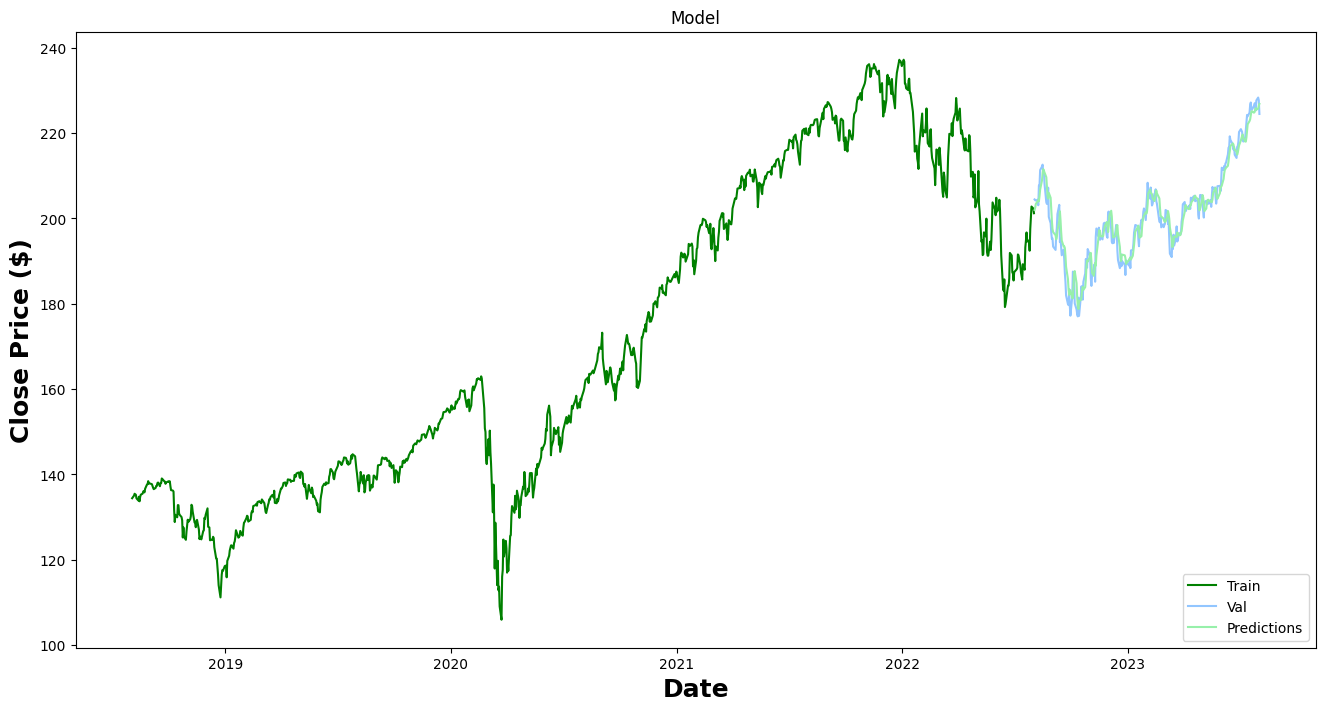

In [ ]:
##
# plot the actual values vs predictions
##

train = close_symbol[:train_size]
valid = close_symbol[train_size:]
valid['Predictions'] = preds

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18, fontweight='bold')
plt.ylabel('Close Price ($)', fontsize=18, fontweight='bold')
plt.plot(train['Close'], color='green')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


Finally, if the model was going to be used for trading decisions (not recommended!) it needs to predict tomorow's (currently unobserverd) closing price. It predicts the closing price for 8/22/23 to be 225.74. In reality, makets closed down sharply overall with VTI falling to 224.50.

In [ ]:

##
# predict for next day (currently unobserved)
#

tmrw_x_scaled = []
tmrw_x_scaled.append(close_symbol_arr_scaled[len(close_symbol_arr_scaled)-lookback:len(close_symbol_arr_scaled), 0])
tmrw_x_scaled = np.array(tmrw_x_scaled)

tmrw_x_scaled = np.reshape(tmrw_x_scaled,
                             (tmrw_x_scaled.shape[0],
                             tmrw_x_scaled.shape[1], 1))

pred_tmrw = model.predict(tmrw_x_scaled)
pred_tmrw = sc.inverse_transform(pred_tmrw)

print(pred_tmrw)


1/1 [==============================] - 0s 31ms/step
[[225.7346]]


In [ ]:
!pip install nbconvert
